In [136]:
%autosave 0
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from datetime import date

Autosave disabled


# Importation des données et pré-traitements

## Chargement du fichier

In [137]:
data = pd.read_csv("interstate_traffic.csv")
data.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


## Conversion au format date

In [138]:
print(type(data['date_time'][0]))
data['date_time'] = pd.to_datetime(data['date_time'])
print(type(data['date_time'][0]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Colonne date mise en index du dataframe

In [139]:
data.set_index('date_time', inplace=True)
data.index

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=48204, freq=None)

=> 1ère alerte : freq est indiquée à "None" -> probablement des intervales non constants

## visualisation des données

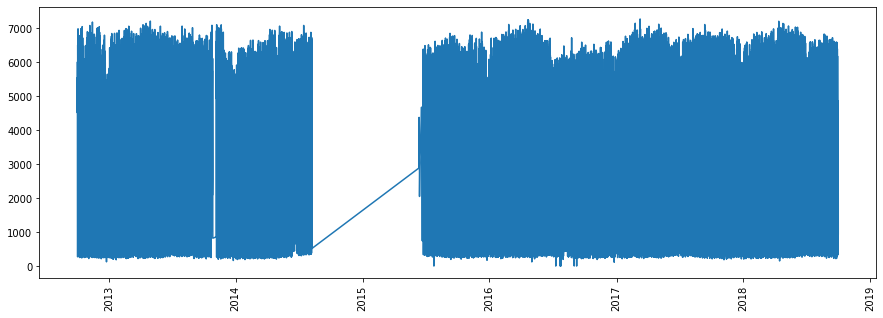

In [141]:
plt.figure(figsize=(15,5))
plt.plot(data['traffic_volume']);
plt.xticks(rotation=90);

=> On voit plusieurs trous important dans les données qu'il faut écarter avant l'analyse

## Vérification des intervales temporels

In [147]:
time_delta = pd.DataFrame(data.index).diff()
time_delta.head()

,date_time
0,NaT
1,01:00:00
2,01:00:00
3,01:00:00
4,01:00:00


In [148]:
time_delta = time_delta[1:]

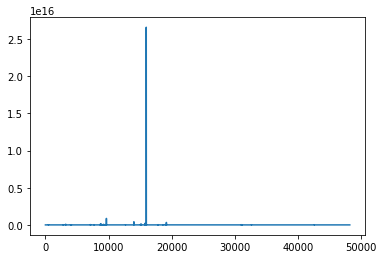

In [149]:
plt.plot(time_delta.values);

## traitement d'un sous-dataset sans périodes creuses trop longues

In [150]:
data = data[data.index.year >= 2016]

In [151]:
data = pd.DataFrame(data['traffic_volume'])

In [154]:
data.shape

(27860, 1)

In [155]:
data.head()

,traffic_volume
date_time,
2016-01-01 00:00:00,1513
2016-01-01 00:00:00,1513
2016-01-01 01:00:00,1550
2016-01-01 03:00:00,719
2016-01-01 04:00:00,533


=> on remarque des doublons de lignes -> à supprimer des données

## suppression des doublons

In [156]:
deleted_lines = 0
datata_lines = data.shape[0]
for i in range(datata_lines-1, 0, -1):
    if data.index[i] == data.index[i-1]:
        data = data.drop(data.index[i])
        deleted_lines += 1
        
print("nombre de lignes doublons supprimées : ", deleted_lines)

nombre de lignes doublons supprimées :  3469


In [157]:
data.shape

(19615, 1)

In [158]:
data.describe()

,traffic_volume
count,19615.000000
mean,3335.791690
std,1963.492407
min,0.000000
25%,1334.500000
50%,3540.000000
75%,4947.000000
max,7280.000000


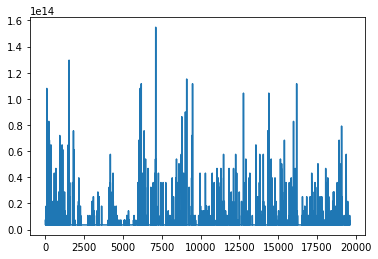

In [159]:
time_delta = pd.DataFrame(data.index)
time_delta = time_delta.diff()
time_delta = time_delta[1:]
plt.plot(time_delta.values);

=> les intervales de temps ne sont toujors pas constant même dans ce dataset réduit -> à corriger

## Changement de l'intervalle de temps minimum : 1h -> données journalières

In [160]:
data = data.resample('d').mean()

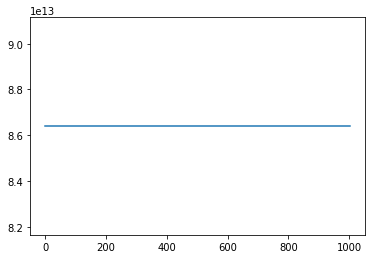

In [161]:
time_delta = pd.DataFrame(data.index)
time_delta = time_delta.diff()
time_delta = time_delta[1:]
plt.plot(time_delta.values);

=> cette fois-ci l'on n'a bien obtenu un jeu de données à intervalle constant

In [162]:
data[data['traffic_volume'].isna()]

,traffic_volume
date_time,
2016-11-30,NaN
2017-01-21,NaN
2017-05-01,NaN


=> nouveau problème, la fonction de ré-échantillonage a du manquer de données et certaines valeurs sont manquantes

## Nouvelle réduction de la taille du dataset pour avoir des données continues

In [163]:
data = data[data.index.year >= 2018]

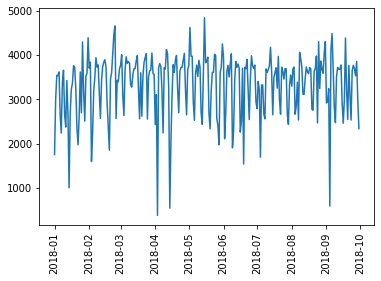

In [164]:
plt.plot(data['traffic_volume']);
plt.xticks(rotation=90);

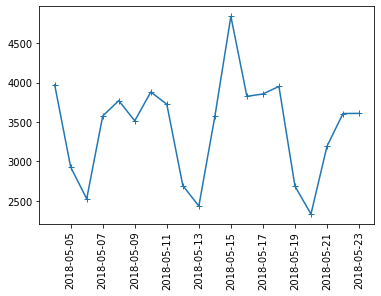

In [165]:
plt.plot(data['traffic_volume'][-150:-130], '-+');
plt.xticks(rotation=90);

- tendance : la moyenne est stable, pas de tendance claire
- saisonnabilité : oui

# Analyse des données

## Analyse en fréquence pour déterminer la période des oscillations

In [166]:
magnitude = np.fft.rfft(data['traffic_volume'])
freq = np.fft.rfftfreq(data.shape[0])

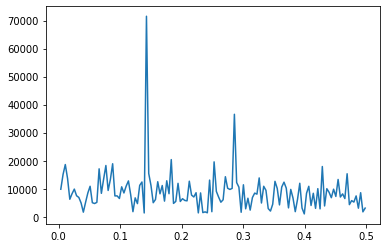

In [169]:
plt.figure()
plt.plot(freq[1:], np.absolute(magnitude[1:]));

In [170]:
1/freq[magnitude == max(magnitude[1:])]

array([3.5])

=> on retient une période entière = 2 x 3.5 = 7 jours,
période hebdomadaire qui semble logique pour du traffic routier

## Décomposition temporelle

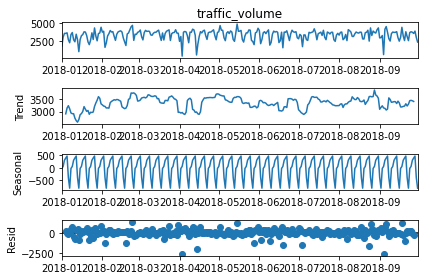

In [204]:
result = seasonal_decompose(data['traffic_volume'], model='additive',
                           period=7)
result.plot();

## Stationnarité

In [129]:
from statsmodels.tsa.stattools import adfuller

In [132]:
adfuller(data.iloc[10:-10, 0])

(-3.943043760483265,
 0.001739941788961215,
 14,
 238,
 {'1%': -3.458128284586202,
  '5%': -2.873761835239286,
  '10%': -2.5732834559706235},
 3699.538110844068)

In [133]:
adfuller(result.resid[10:-10])

(-8.350594891049058,
 3.002099343337298e-13,
 16,
 236,
 {'1%': -3.4583663275730476,
  '5%': -2.8738660999177132,
  '10%': -2.5733390785693766},
 3479.0032625343424)

-> après la décomposition, les résidus sont plus stationnaires que la série initiale (p-value << 0)

## Autocorrélation

In [177]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### totale ACF

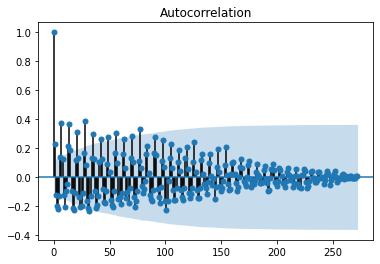

In [175]:
plot_acf(data, lags=data.shape[0]-1);

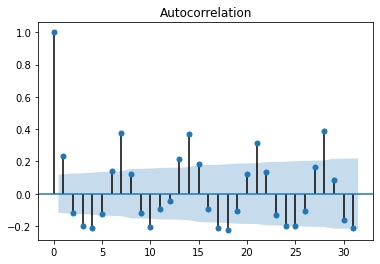

In [176]:
plot_acf(data, lags=31);

### partielle PCAF

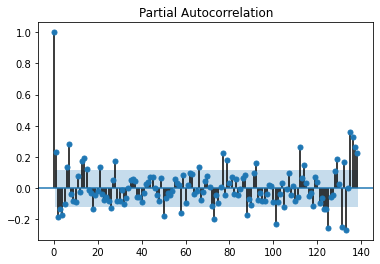

In [198]:
plot_pacf(data, lags=int((data.shape[0]+3)/2))

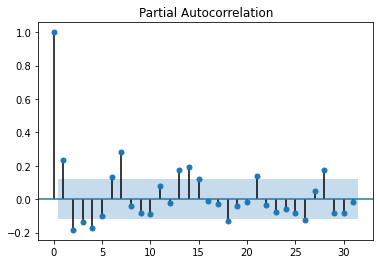

In [200]:
plot_pacf(data, lags=31);

# Construction du modèle

## Détermination des paramètres du modèle

choix du paramètre p (pour l'autorégression) : tel que la PACF passe sous les intervalles de confiance à partir de p+1
(Si PACF décroit régulièrement de façon exponentielle sans pic, le modèle sera un MA pur, p = 0)

=> p = 4

choix du paramètre q (pour la moyenne glissante) : tel que l'ACF passe sous les intervalles de confiance à partir de q+1
(Si ACF décroit régulièrement de façon exponentielle sans pic, le modèle sera un AR pur, q = 0)

=> q = 7

## Séparation des données

,resid
date_time,
2018-01-04,237.639618
2018-01-05,9.527102
2018-01-06,-185.851166
2018-01-07,-60.197128
2018-01-08,461.231616


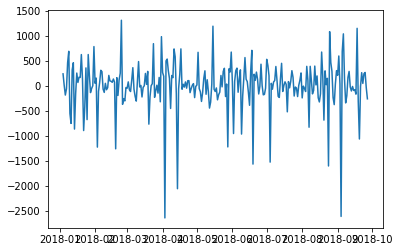

In [285]:
residus = pd.DataFrame(result.resid.dropna())
plt.plot(residus);
residus.head()

In [286]:
train = residus[:int(0.9*len(residus))]
val = residus[int(0.9*len(residus)):]
print('taille train : ', len(train))
print('taille val : ', len(val))

taille train :  240
taille val :  27


## Entraînement du modèle

In [291]:
from statsmodels.tsa.arima_model import ARMA
ar1 = ARMA(train, (3, 1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  resid   No. Observations:                  240
Model:                     ARMA(3, 1)   Log Likelihood               -1749.132
Method:                       css-mle   S.D. of innovations            349.500
Date:                Wed, 25 Mar 2020   AIC                           3510.264
Time:                        15:18:47   BIC                           3531.148
Sample:                    01-04-2018   HQIC                          3518.678
                         - 08-31-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0315      0.320      0.098      0.922      -0.596       0.659
ar.L1.resid     0.4237      0.063      6.748      0.000       0.301       0.547
ar.L2.resid    -0.2131      0.067     -3.191      0.001      -0.344      -0.082
ar.L3.resid    -0.2295      0.062     -3.672      0.000      -0.352      -0.107
ma.L1.resid    -1.0000      0.011    -94.655      0.000      -1.021      -0.979
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7497           -1.1102j            1.3396           -0.1555
AR.2            0.7497           +1.1102j            1.3396            0.1555
AR.3           -2.4282           -0.0000j            2.4282           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

## évaluation sur train

In [295]:
preds = ar1.fittedvalues

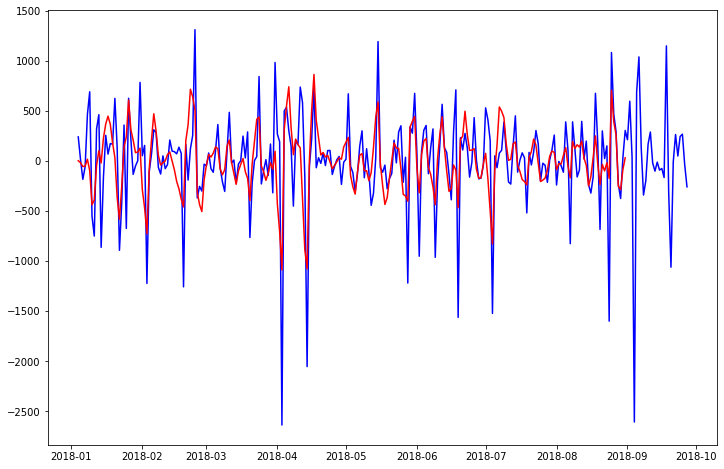

In [296]:
plt.figure(figsize=(12, 8))
plt.plot(residus, color='blue')
plt.plot(preds, color='red');

## forecast test

In [304]:
forecast = ar1.forecast(steps=len(val))[0]

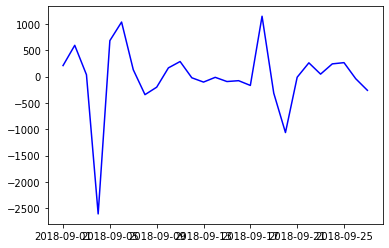

In [316]:
plt.plot(val, color='blue');

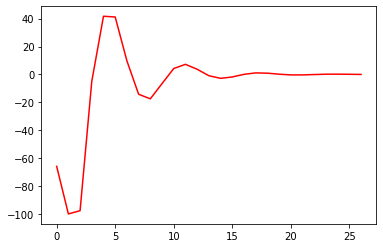

In [312]:
plt.plot(forecast, color='red');